# Reclassify Unsupervised NDVI

## Background

## Description


---

## Getting Started

To run this analysis, run all the cells in the notebook, starting with the "**Load packages**" cell.

### Load packages

In [1]:
import datacube
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from tqdm import tqdm
import glob

from datacube.utils import geometry
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.temporal import temporal_statistics, xr_phenology
from deafrica_tools.dask import create_local_dask_cluster
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

### Analysis parameters

The following cell sets important parameters for the analysis:

* `vector_file`: file path for the shapefile containing the polygon for the boundary of the area of interest
* `attribute_col`: The column in the "vector_file" containing the names of the 'urban commune' or FR 'commune urbaine', 'rural commune' or FR 'commune rurale', and 'administrative post' or FR 'poste administratif'
* `output_dir` : The directory in which to store results from the analysis.
* `commune`: In this analysis, we'll select a Niger commune/administrative post, to mask the dataset and analysis.
* `no_of_clusters` : The number of clusters used in the K-Means clustering in the [previous notebook](01_unsupervised_class_identification.ipynb).
* `time_old` : This is the time period of interest from the [previous notebook](01_unsupervised_class_identification.ipynb).
* `pickled_prediction` : The file path to the pickled clustering prediction result from the [previous notebook](01_unsupervised_class_identification.ipynb).
* `ndvi_groups_fn` : File name pattern to use when searching for the pickled NDVI profiles files.
* `ndvi_timeseries_fp` : File path to the time series saved from the [previouse notebook](02_group_classes_using_NDVI.ipynb)

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [2]:
vector_file = "data/boundary_data/communes_etude.geojson"
attribute_col = "NOM_COM"

# Directory to store the results.
output_dir = "results"

# The number of clusters used in the K-Means clustering in the previous notebook. 
no_of_clusters = 15

# Time period of interest from the previous notebook.
time_old = "2021"

# File paths of results from the previouse notebook.
pickled_prediction = f"{output_dir}/niger_communes_kmeans_{no_of_clusters}_predicted_{time_old}.pickle"
ndvi_groups_fn = f"{output_dir}/niger_communes_correlated_ndvi*.pickle"
ndvi_timeseries_fp = f"{output_dir}/niger_communes_ndvitimeseries_18month_{no_of_clusters}classes.csv"

## From interactive exploration of profiles:

In [3]:
files = glob.glob(ndvi_groups_fn)

groups = {}

for i, file in enumerate(files):
    with open(file, "rb") as f:
        groups[i] = pickle.load(f)
        
print(groups)

{0: ['Class_1', 'Class_3', 'Class_5'], 1: ['Class_12', 'Class_14'], 2: ['Class_9'], 3: ['Class_0', 'Class_2', 'Class_4', 'Class_6', 'Class_7', 'Class_8', 'Class_10', 'Class_11', 'Class_13']}


In [4]:
len(groups)

4

In [5]:
timeseries_df = pd.read_csv(ndvi_timeseries_fp)

timeseries_df.head()

,time,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14
0,2020-10-18,0.264499,0.474066,0.181395,0.374428,0.280353,0.277008,0.178109,0.299306,0.297367,-0.120592,0.228819,0.338197,0.118518,0.157310,0.122568
1,2020-11-01,0.254838,0.568708,0.173946,0.413914,0.269604,0.397535,0.171687,0.305230,0.278079,-0.239692,0.217142,0.332240,0.120978,0.164432,0.133607
2,2020-11-15,0.237864,0.520581,0.167025,0.380896,0.250755,0.357916,0.164396,0.283735,0.254943,-0.219782,0.204437,0.300967,0.118403,0.158283,0.129882
3,2020-11-29,0.227086,0.529885,0.162492,0.379515,0.243251,0.359970,0.158180,0.278922,0.242622,-0.240061,0.197627,0.288590,0.115166,0.155779,0.126428
4,2020-12-13,0.210474,0.538982,0.154804,0.376924,0.232887,0.366563,0.148000,0.273036,0.225791,-0.271680,0.187100,0.274587,0.110668,0.152104,0.122575


In [6]:
with open(pickled_prediction, "rb") as f:
    x_val, y_val, pred_val, pred_crs = pickle.load(f)
    
predicted = xr.DataArray(
    data=pred_val,
    dims=["y", "x"],
    coords=dict(
        x=x_val,
        y=y_val,
    ),
    attrs=dict(
        crs=pred_crs,
    ),
).transpose("y", "x")

print(predicted)

<xarray.DataArray (y: 7234, x: 3344)>
array([[12., 12., 12., ...,  2.,  2.,  2.],
       [14., 14., 14., ...,  2.,  2.,  2.],
       [14., 14., 14., ...,  2.,  2.,  2.],
       ...,
       [ 3.,  3.,  3., ...,  7.,  7.,  3.],
       [ 3.,  3.,  3., ...,  3.,  3.,  3.],
       [ 3.,  3.,  3., ...,  3.,  1.,  3.]])
Coordinates:
  * x        (x) float64 2.368e+05 2.368e+05 2.369e+05 ... 3.037e+05 3.037e+05
  * y        (y) float64 1.754e+06 1.754e+06 1.754e+06 ... 1.609e+06 1.609e+06
Attributes:
    crs:      EPSG:6933


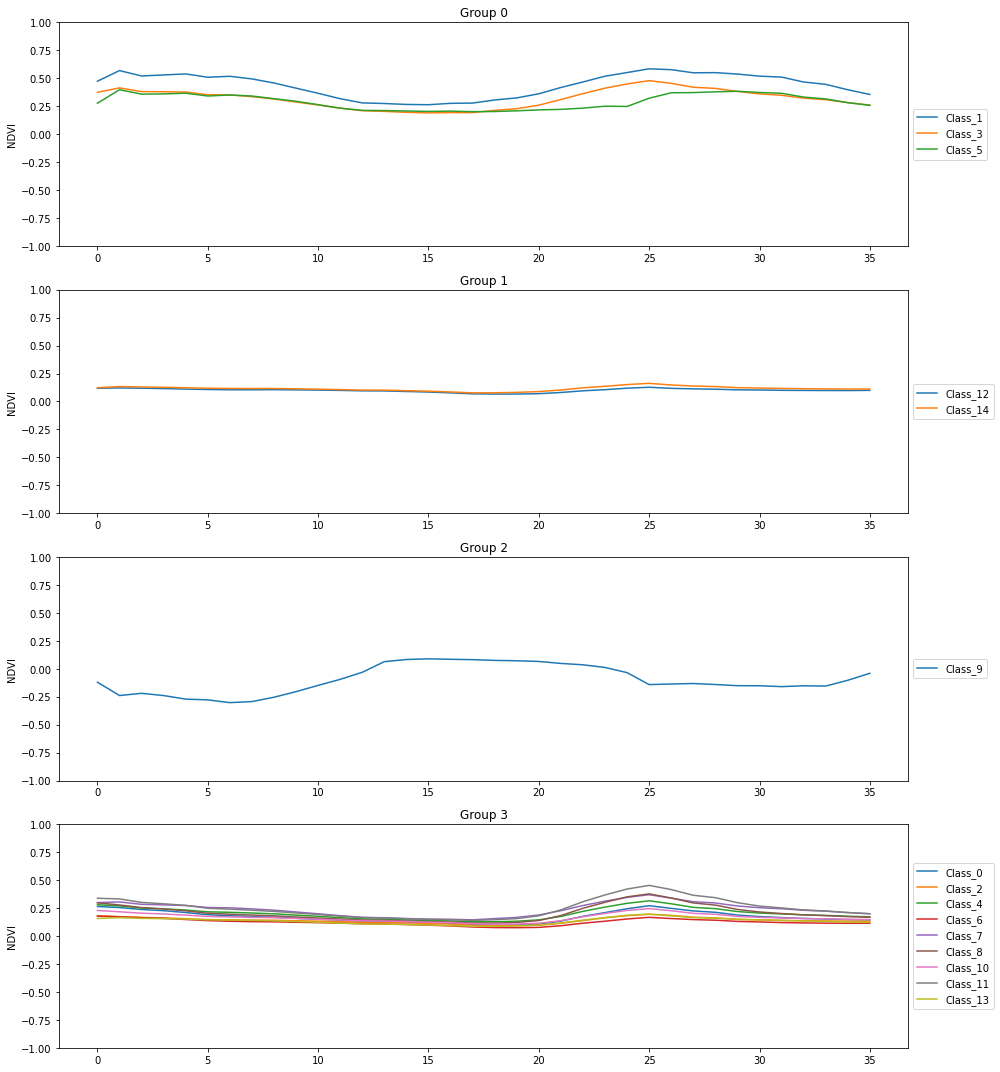

In [7]:
fig = plt.figure(figsize=(14, 15), facecolor="white")

rows = len(groups)
columns = 1

for i in range(rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    
    for class_id in groups[i]:
        timeseries_df[class_id].plot(ax=ax)
    
    ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
    ax.set_ylim((-1, 1))
    ax.set_title(f"Group {i}")
    ax.set_ylabel("NDVI")

plt.tight_layout()

In [8]:
mask_list = []

for key in groups:
    
    crop_ids = [int(crop_id.split("_")[-1]) for crop_id in groups[key]]
    
    single_mask = xr.where(predicted.isin(crop_ids), key+1, 0)
    
    mask_list.append(single_mask)
    
grouped_classes_xr = mask_list[0].copy()

for mask in mask_list[1:]:
    grouped_classes_xr += mask

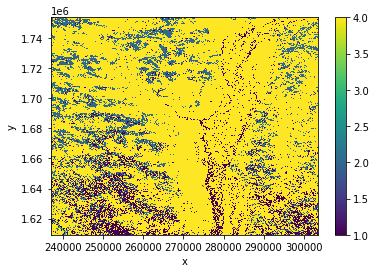

In [9]:
grouped_classes_xr.plot()